# **Introduction**

Face Detection Systems have great uses in today’s world which demands security, accessibility or joy! Today, we will be building a model that can plot 15 key points on a face.

Face Landmark Detection models form various features we see in social media apps. The face filters you find on Instagram are a common use case. The algorithm aligns the mask on the image keeping the face landmarks as base points.

In this notebook, we'll develop a model which marks keypoints on a given image of a human face. We'll build a Convolutional Neural Network which takes an image and returns a array of keypoints.

We'll require a GPU Hardware accelerator for training the model. Change the runtime type to GPU by going to Tools > Change Runtime Type > Hardware Accelerator > GPU.

![](https://miro.medium.com/max/2000/1*qNNr1hrFoaeAWru7VI0SbQ.png)

# **Reading data and Preprocessing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
# Plotting images with landmarks
def plot_image_landmarks(img_array, df_landmarks, index):
    plt.imshow(img_array[index, :, :, 0], cmap = 'gray')
    plt.scatter(df_landmarks.iloc[index][0: -1: 2], df_landmarks.iloc[index][1: : 2], c = 'y')
    plt.show()

In [5]:
features = np.load('../../dataset/facelandmark/face_images.npz')
features = features.get(features.files[0]) # images
features = np.moveaxis(features, -1, 0)
features = features.reshape(features.shape[0], features.shape[1], features.shape[1], 1)

In [6]:
keypoints = pd.read_csv('../../dataset/facelandmark/facial_keypoints.csv')
keypoints.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [7]:
# Cleaing data
keypoints = keypoints.fillna(0)
num_missing_keypoints = keypoints.isnull().sum(axis = 1)
num_missing_keypoints

0       0
1       0
2       0
3       0
4       0
       ..
7044    0
7045    0
7046    0
7047    0
7048    0
Length: 7049, dtype: int64

In [8]:
new_features = features[keypoints.index.values, :, :, :] #Nums of rows,w, H, Channels
new_features = new_features / 255
keypoints.reset_index(inplace = True, drop = True)

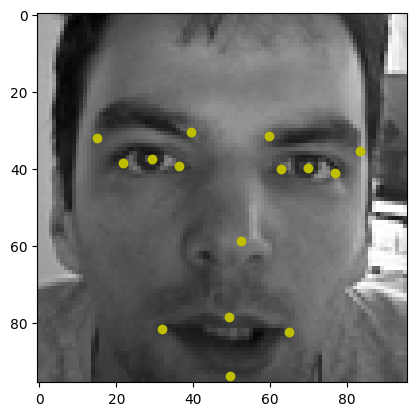

In [9]:
plot_image_landmarks(new_features, keypoints, 5)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(new_features, keypoints, test_size=0.2)

# **Our Model**

In [11]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam

**kernel_initializer** in Keras : Initializers define the way to set the initial random weights of Keras layers.

**glorot_uniform()** : It draws samples from a uniform distribution within [-limit, limit] where limit is sqrt(6 / (fan_in + fan_out)) where fan_in is the number of input units in the weight tensor and fan_out is the number of output units in the weight tensor.

We are using **the Mean Squared Error** as we are performing a regression task. A small learning rate is always good if you have a good amount of data

In [12]:
img_size = 96

In [13]:
model = Sequential()

model.add(Input(shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))  

model.add(Flatten())
model.add(Dense(256,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5)) 

model.add(Dense(64,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0))

model.add(Dense(30,kernel_initializer=glorot_uniform()))

model.summary()
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mean_squared_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 96, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       1

In [14]:
BATCH_SIZE = 100
EPOCHS = 150

# **Training Model**

In [13]:
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1,
)


Epoch 1/150
57/57 [==============================] - 10s 49ms/step - loss: 659.5972 - mean_squared_error: 659.5972 - val_loss: 845.7542 - val_mean_squared_error: 845.7542
Epoch 2/150
57/57 [==============================] - 2s 28ms/step - loss: 312.2801 - mean_squared_error: 312.2801 - val_loss: 684.4431 - val_mean_squared_error: 684.4431
Epoch 3/150
57/57 [==============================] - 2s 28ms/step - loss: 241.9560 - mean_squared_error: 241.9560 - val_loss: 915.1838 - val_mean_squared_error: 915.1838
Epoch 4/150
57/57 [==============================] - 2s 28ms/step - loss: 193.1594 - mean_squared_error: 193.1594 - val_loss: 996.1920 - val_mean_squared_error: 996.1920
Epoch 5/150
57/57 [==============================] - 2s 28ms/step - loss: 171.7250 - mean_squared_error: 171.7250 - val_loss: 1182.2400 - val_mean_squared_error: 1182.2400
Epoch 6/150
57/57 [==============================] - 2s 28ms/step - loss: 175.1323 - mean_squared_error: 175.1323 - val_loss: 879.5189 - val_mean_s

In [15]:
plt.plot(history.history['mean_squared_error'], label='MSE (training data)')
plt.plot(history.history['val_mean_squared_error'], label='MSE (validation data)')
plt.title('MSE for Facial keypoints')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

NameError: name 'history' is not defined

# **Model Evaluation**

In [15]:
y_pred = model.predict(x_test)
y_pred

array([[62.212467  , 34.79511   , 27.455824  , ...,  0.53399855,
        47.242645  , 75.15147   ],
       [67.48596   , 41.0685    , 31.332184  , ...,  0.22538191,
        43.990444  , 77.507164  ],
       [64.64891   , 36.50058   , 30.274904  , ..., -0.40261644,
        48.519108  , 73.11352   ],
       ...,
       [65.032364  , 38.419785  , 29.754112  , ...,  0.35643202,
        46.18418   , 77.11667   ],
       [66.378975  , 39.836735  , 31.705467  , ..., -0.10323995,
        45.906853  , 75.16227   ],
       [60.884647  , 35.31669   , 28.247564  , ...,  4.4030466 ,
        43.87506   , 72.08686   ]], dtype=float32)

In [16]:
def plot_img_preds(images, truth, pred, index):
    plt.imshow(images[index, :, :, 0], cmap = 'gray')
    
    t = np.array(truth)[index]
    plt.scatter(t[0::2], t[1::2], c = 'y')
    
    p = pred[index, :]
    plt.scatter(p[0::2], p[1::2], c = 'r')
    
    plt.show()

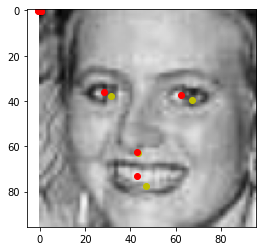

In [17]:
plot_img_preds(x_test, y_test, y_pred, 3)

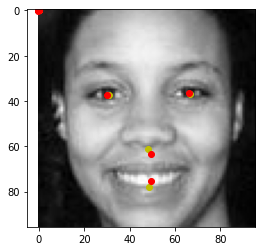

In [18]:
plot_img_preds(x_test, y_test, y_pred, 18)